# Sampta Experience III

Description : 

In [1]:
import numpy as np
import pyshtools
import spherical_inr as sph
import matplotlib.pyplot as plt


import torch
from sklearn.preprocessing import StandardScaler

In [1]:
def compute_snr(image, noisy_image):
    """
    Computes the Signal-to-Noise Ratio (SNR) between two images.
    """
    
    signal_power = np.mean(np.square(image))
    noise_power = np.mean(np.square(image - noisy_image))
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
L = 150
phi, theta, (nlon, nlat) = sph.sample_s2(L, sampling = "gl", torch_tensor = True)

N_val = 5000
phi_val, theta_val = sph.sample_s2_uniform(N_val, torch_tensor = True)

L_test = 300
phi_test, theta_test, (nlon_test, nlat_test) = sph.sample_s2(L_test, sampling = "gl", torch_tensor = True)

In [4]:
coefficients_train = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 150)
coefficients_test = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 300)

In [5]:
world_map = coefficients_train.expand(lon = phi.numpy().flatten(),  colat = theta.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat, nlon)
world_map_val = coefficients_train.expand(lon = phi_val.numpy().flatten(), colat = theta_val.numpy().flatten(), degrees=False, nthreads=0).reshape(N_val)
world_map_test = coefficients_test.expand(lon = phi_test.numpy().flatten(), colat = theta_test.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat_test, nlon_test)

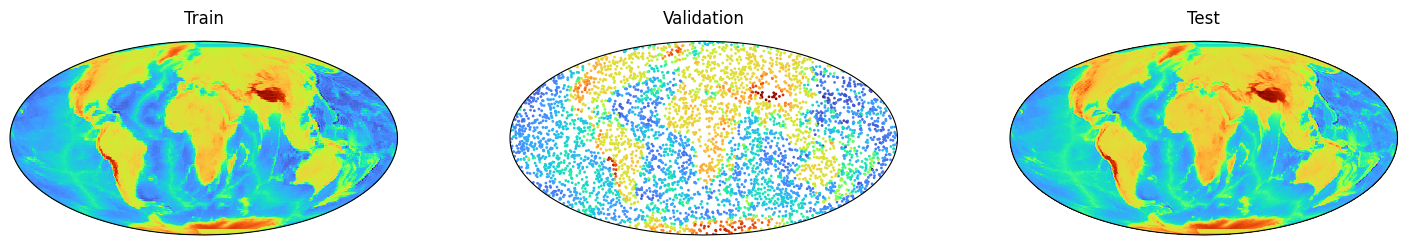

In [6]:
fig = plt.figure(figsize=(15, 5))
subfigs = fig.subfigures(1, 3)
sph.plot_sphere(world_map, molweide=True, cmap = "turbo", title = "Train", fig = subfigs[0])
sph.plot_sphere_scatter(world_map_val, lon = phi_val, lat = theta_val, molweide=True, cmap = "turbo", title = "Validation", fig = subfigs[1], s = 1)
sph.plot_sphere(world_map_test, molweide=True, cmap = "turbo", title = "Test", fig = subfigs[2])
plt.show()

In [7]:
scaler = StandardScaler()
world_map_scaled = scaler.fit_transform(world_map.reshape(-1, 1)).reshape(nlat, nlon)
world_map_val_scaled = scaler.transform(world_map_val.reshape(-1, 1)).reshape(N_val)


X = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()
y = torch.tensor(world_map_scaled.copy()).flatten().unsqueeze(1).float()

X_val = torch.stack([theta_val.flatten(), phi_val.flatten()], dim=-1).float()
y_val = torch.tensor(world_map_val_scaled.copy()).flatten().unsqueeze(1).float()

X_test = torch.stack([theta_test.flatten(), phi_test.flatten()], dim=-1).float()

# Move tensors to the selected device
X = X.to(device)
y = y.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

In [20]:
activation_degrees = [(10, 3), (10, 5), (10, 10), (20, 3), (20, 5)]
alphas = [(1, 1), (1, 1), (2, 2), (2, 2), (2, 2)]
dict_train_losses = {}
dict_test_losses = {}
dict_predictions = {}

In [22]:
for (deg_first, deg_subseq), (alpha_first, alpha_subseq) in zip(activation_degrees, alphas):

    shinr = sph.SphericalNet(

        L0 = 15, 
        Q = 3,
        hidden_features = 100, 
        spectral_norm=True,
        activation = sph.Chebyshev(order = deg_subseq, alpha = alpha_first), 
        first_activation=sph.Chebyshev(order = deg_first, alpha = alpha_subseq), 
        device=device
        
    )

    dict_train_losses[(deg_first, deg_subseq)], dict_test_losses[(deg_first, deg_subseq)] = sph.train(
        model = shinr, 
        x = X, 
        y = y, 
        epochs = 1000,#000, 
        batch_size=2048,
        optimizer = torch.optim.Adam(shinr.parameters(), lr=1e-3),
        loss_fn= torch.nn.MSELoss(), 
        validation_data=(X_val, y_val),
        device=device
        )
    
    pred = shinr(X_test).cpu().detach().numpy()
    dict_predictions[(deg_first, deg_subseq)] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat_test, nlon_test)


In [ ]:
shinr = sph.SphericalNet(

    L0 = 15, 
    Q = 3,
    hidden_features = 100, 
    activation = torch.sin, 
    first_activation=lambda x : torch.sin(5*x),
    device=device    
)

dict_train_losses["SphericalSIREN"], dict_test_losses["SphericalSIREN"] = sph.train(
    model = shinr, 
    x = X, 
    y = y, 
    epochs = 1000,#000, 
    batch_size=2048,
    optimizer = torch.optim.Adam(shinr.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(),
    validation_data=(X_val, y_val),
    device=device
    )

pred = shinr(X_test).detach().numpy()
dict_predictions["SphericalSIREN"] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat_test, nlon_test)

In [15]:
siren = sph.SirenNet(

    in_features=2, 
    hidden_features=100,
    n_hidden_layers=5,
    out_features=1,
    first_omega_0=5.0,
    hidden_omega=5.0,
    
).to(device)


dict_train_losses["SIREN"], dict_test_losses["SIREN"] = sph.train(
    model = siren, 
    x = X, 
    y = y, 
    epochs = 1000,#000, 
    batch_size=2048,
    optimizer = torch.optim.Adam(siren.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(), 
    validation_data=(X_val, y_val),
    device = device
    )


pred = siren(X_test).detach().numpy()
dict_predictions["SIREN"] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat_test, nlon_test)

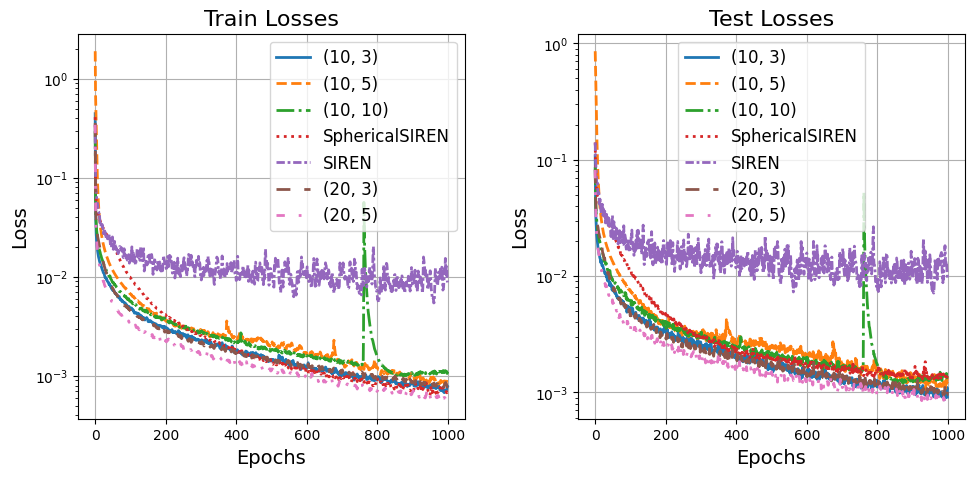

In [23]:
fig = plt.figure(figsize=(10, 5))
subfigs = fig.subfigures(1, 2)
sph.plot_losses(dict_train_losses, fig = subfigs[0], title = "Train Losses")
sph.plot_losses(dict_test_losses, fig = subfigs[1], title = "Test Losses")
plt.savefig("figures/losses.pdf")
plt.show()

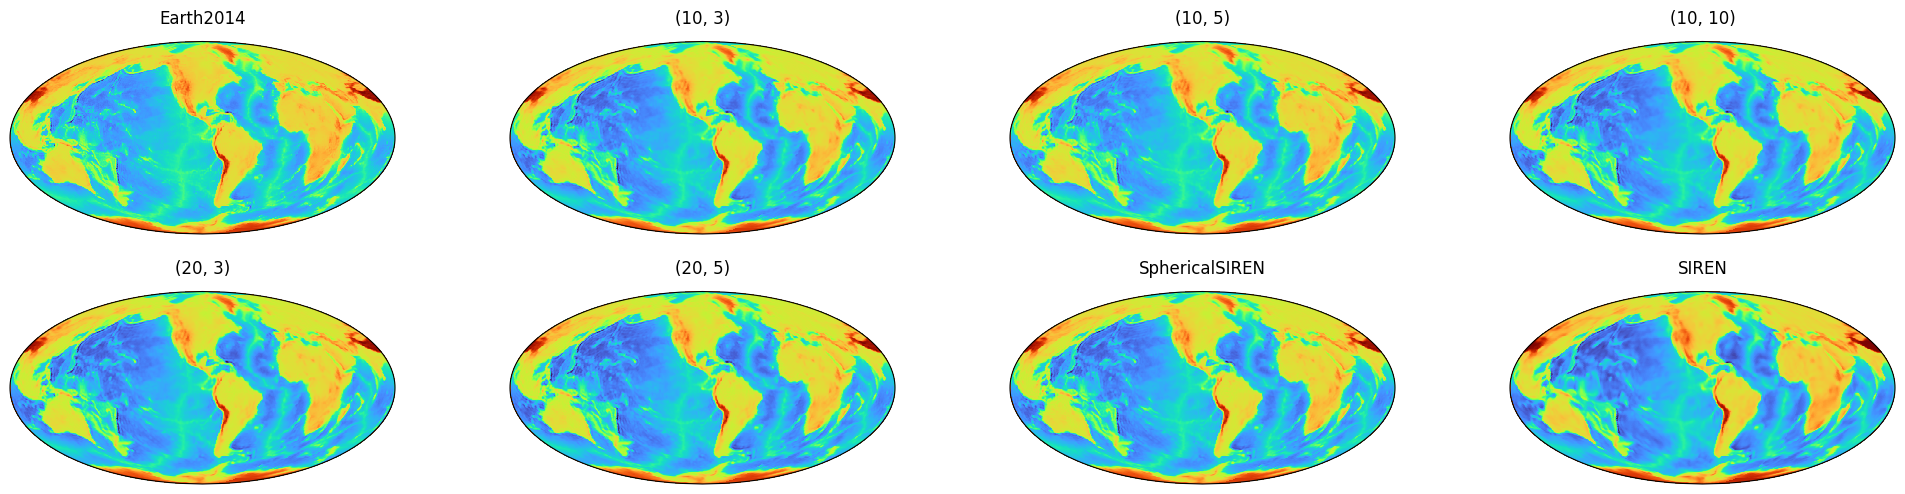

In [24]:
fig = plt.figure(figsize=(20, 5))
subfigs = fig.subfigures(2, 4)
subfigs = subfigs.flatten()

for i, (label, pred) in enumerate(dict_predictions.items()):
    sph.plot_sphere(pred, cmap = "turbo", title = label, central_latitude=40, central_longitude=-90, fig=subfigs[i+1], molweide=True)

sph.plot_sphere(world_map_test, cmap = "turbo", title = "Earth2014", central_latitude=40, central_longitude=-90, fig=subfigs[0], molweide=True)
plt.savefig("figures/predictions.pdf")
plt.show()